# Chapter 4: Default Archetype Analysis

**Research Question**: *"Among firms that actually default, are there distinct 'archetypes' based on their SHAP profiles — i.e., different pathways to default?"*

## Motivation:
Previous chapters showed that LightGBM uses 40 features with significant interactions to predict default risk. However, clustering all firms by SHAP values primarily separates high-risk from low-risk — which is almost tautological. 

A more insightful approach is to cluster **only the defaulting firms** to discover whether there are distinct "failure modes" — different combinations of risk factors that lead to the same outcome (default).

## Objectives:
1. Filter to defaulting firms only
2. Cluster defaults based on their SHAP value patterns
3. Identify distinct default archetypes (e.g., leverage-driven, liquidity-driven, profitability-driven)
4. Characterize each archetype's distinguishing risk factors

## Key Insight:
By clustering defaults only, we can uncover heterogeneity *within* the default population. Two firms that both default might have very different risk profiles — understanding these archetypes can inform targeted early warning systems and differentiated credit policies.

---

In [51]:
import sys
from pathlib import Path
import pickle
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

# UMAP for 2D visualization
try:
    import umap
    UMAP_AVAILABLE = True
except ImportError:
    print("⚠ umap-learn not installed. Run: pip install umap-learn")
    print("  Will use PCA for 2D visualization instead.")
    UMAP_AVAILABLE = False

PROJ_ROOT = Path.cwd().parent
if str(PROJ_ROOT) not in sys.path:
    sys.path.append(str(PROJ_ROOT))

# Import model version configuration - change ACTIVE_MODEL_VERSION in config.py to switch
from credit_risk_xai.config import (
    ACTIVE_MODEL_VERSION,
    ACTIVE_FEATURES,
    ACTIVE_FEATURE_NAME_MAP,
    get_display_name,
)

# Plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

print(f"Project root: {PROJ_ROOT}")
print(f"UMAP available: {UMAP_AVAILABLE}")
print(f"=" * 60)
print(f"ACTIVE MODEL VERSION: {ACTIVE_MODEL_VERSION}")
print(f"Number of features: {len(ACTIVE_FEATURES)}")
print(f"=" * 60)

Project root: /Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis
UMAP available: True


## 1. Load SHAP Cache and Filter to Defaults

In [52]:
# Load SHAP cache from Chapter 1
cache_file = PROJ_ROOT / "results" / "xai_exploration" / "shap_cache.pkl"

print(f"Loading SHAP cache from: {cache_file}")
with open(cache_file, 'rb') as f:
    shap_cache = pickle.load(f)

# Extract data
X_val = shap_cache['X_val']
y_val = shap_cache['y_val']
y_pred_lgbm = shap_cache['y_pred_proba_lgbm']
y_pred_logit = shap_cache['y_pred_proba_logit']
shap_values_lgbm = shap_cache['shap_values_lgbm']
feature_names = shap_cache['feature_names']

print(f"\n✓ Loaded full validation set:")
print(f"  • Total observations: {len(X_val):,}")
print(f"  • Features: {len(feature_names)}")
print(f"  • Defaults: {y_val.sum():,} ({y_val.mean()*100:.2f}%)")
print(f"  • Non-defaults: {(~y_val.astype(bool)).sum():,}")

# Filter to defaults only
default_mask = y_val.values == 1
X_defaults = X_val[default_mask]
shap_defaults = shap_values_lgbm[default_mask]
pd_defaults_lgbm = y_pred_lgbm[default_mask]
pd_defaults_logit = y_pred_logit[default_mask]

print(f"\n✓ Filtered to defaults only:")
print(f"  • Default observations: {len(X_defaults):,}")
print(f"  • SHAP values shape: {shap_defaults.shape}")
print(f"  • Mean predicted PD: {pd_defaults_lgbm.mean()*100:.2f}%")
print(f"  • Median predicted PD: {np.median(pd_defaults_lgbm)*100:.2f}%")

Loading SHAP cache from: /Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/results/xai_exploration/shap_cache.pkl

✓ Loaded full validation set:
  • Total observations: 60,830
  • Features: 29
  • Defaults: 1,071 (1.76%)
  • Non-defaults: 59,759

✓ Filtered to defaults only:
  • Default observations: 1,071
  • SHAP values shape: (1071, 29)
  • Mean predicted PD: 11.35%
  • Median predicted PD: 7.27%


## 2. Preprocessing for Clustering

Steps:
1. **Standardize SHAP values** - Scale to unit variance
2. **PCA** - Reduce dimensionality while preserving 95% variance
3. **UMAP** - Create 2D embedding for visualization

Note: With ~1,000 defaults (vs 60,000 total firms), we can use faster settings.

In [53]:
# Step 1: Standardize SHAP values for defaults
print("Preprocessing SHAP values for clustering (defaults only)...")
print("="*60)

scaler = StandardScaler()
shap_scaled = scaler.fit_transform(shap_defaults)

print(f"\n1. Standardization:")
print(f"   Original SHAP range: [{shap_defaults.min():.3f}, {shap_defaults.max():.3f}]")
print(f"   Scaled SHAP range: [{shap_scaled.min():.3f}, {shap_scaled.max():.3f}]")
print(f"   Scaled mean: {shap_scaled.mean():.6f} (should be ~0)")
print(f"   Scaled std: {shap_scaled.std():.6f} (should be ~1)")

Preprocessing SHAP values for clustering (defaults only)...

1. Standardization:
   Original SHAP range: [-1.293, 1.543]
   Scaled SHAP range: [-5.981, 6.575]
   Scaled mean: -0.000000 (should be ~0)
   Scaled std: 1.000000 (should be ~1)



2. PCA Dimensionality Reduction:
   Original dimensions: 29
   Reduced dimensions: 24
   Variance explained: 95.7%


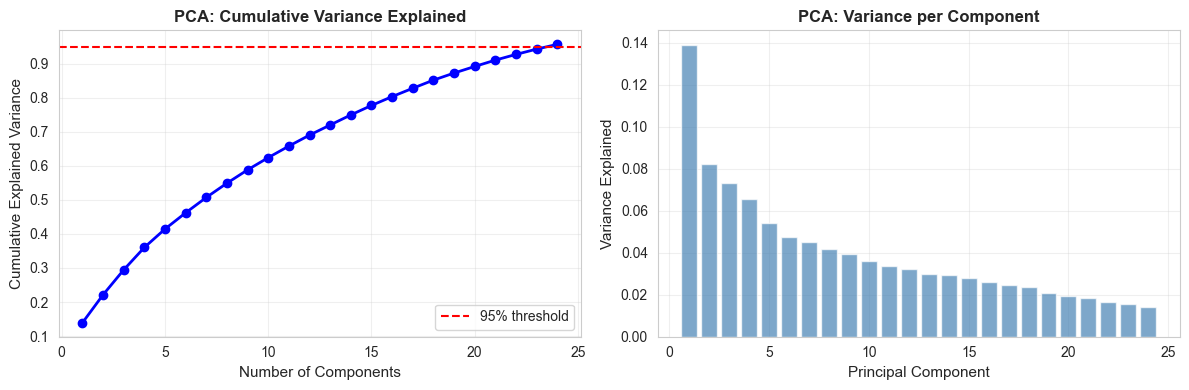


   Top 5 components explain: 41.4% of variance


In [54]:
# Step 2: PCA for dimensionality reduction
print("\n2. PCA Dimensionality Reduction:")

# Fit PCA to capture 95% variance
pca = PCA(n_components=0.95, random_state=42)
shap_pca = pca.fit_transform(shap_scaled)

print(f"   Original dimensions: {shap_scaled.shape[1]}")
print(f"   Reduced dimensions: {shap_pca.shape[1]}")
print(f"   Variance explained: {pca.explained_variance_ratio_.sum()*100:.1f}%")

# Visualize explained variance
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Cumulative variance
cumvar = np.cumsum(pca.explained_variance_ratio_)
axes[0].plot(range(1, len(cumvar)+1), cumvar, 'bo-', linewidth=2, markersize=6)
axes[0].axhline(y=0.95, color='r', linestyle='--', label='95% threshold')
axes[0].set_xlabel('Number of Components', fontsize=11)
axes[0].set_ylabel('Cumulative Explained Variance', fontsize=11)
axes[0].set_title('PCA: Cumulative Variance Explained', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Individual variance
axes[1].bar(range(1, len(pca.explained_variance_ratio_)+1), 
            pca.explained_variance_ratio_, color='steelblue', alpha=0.7)
axes[1].set_xlabel('Principal Component', fontsize=11)
axes[1].set_ylabel('Variance Explained', fontsize=11)
axes[1].set_title('PCA: Variance per Component', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n   Top 5 components explain: {cumvar[4]*100:.1f}% of variance")

In [55]:
# Step 3: UMAP for 2D visualization
print("\n3. UMAP 2D Embedding for Visualization:")

if UMAP_AVAILABLE:
    start_time = time.time()
    reducer = umap.UMAP(
        n_components=2, 
        random_state=42, 
        n_neighbors=15,  # Can use smaller value for smaller dataset
        min_dist=0.1,
        metric='euclidean'
    )
    # Use PCA-reduced data for UMAP
    shap_2d = reducer.fit_transform(shap_pca)
    elapsed = time.time() - start_time
    print(f"   ✓ UMAP completed in {elapsed:.1f}s")
    print(f"   2D embedding shape: {shap_2d.shape}")
else:
    # Fallback to PCA 2D
    pca_2d = PCA(n_components=2, random_state=42)
    shap_2d = pca_2d.fit_transform(shap_scaled)
    print(f"   ✓ Using PCA 2D instead (UMAP not available)")
    print(f"   2D embedding shape: {shap_2d.shape}")

print("\n" + "="*60)
print("Preprocessing complete!")
print(f"Working with {len(shap_defaults):,} defaulting firms")
print("="*60)


3. UMAP 2D Embedding for Visualization:


/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


   ✓ UMAP completed in 1.5s
   2D embedding shape: (1071, 2)

Preprocessing complete!
Working with 1,071 defaulting firms


## 3. Determine Optimal Number of Clusters

With ~1,000 defaults, we test k=2 to 6 (fewer clusters than before due to smaller sample size).

Evaluation metrics:
- **Elbow method**: Inertia (within-cluster sum of squares)
- **Silhouette score**: Measure of cluster cohesion and separation
- **Davies-Bouldin index**: Ratio of within-cluster to between-cluster distances

In [56]:
# Test different values of k (smaller range for smaller dataset)
K_range = range(2, 7)

print("Evaluating cluster counts k=2 to k=6 (defaults only)...")
print("="*60)

results = []
for k in K_range:
    start = time.time()
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    labels = kmeans.fit_predict(shap_pca)
    
    inertia = kmeans.inertia_
    silhouette = silhouette_score(shap_pca, labels)
    db_index = davies_bouldin_score(shap_pca, labels)
    elapsed = time.time() - start
    
    results.append({
        'k': k,
        'inertia': inertia,
        'silhouette': silhouette,
        'davies_bouldin': db_index,
        'time': elapsed
    })
    
    print(f"  k={k}: Silhouette={silhouette:.4f}, DB={db_index:.4f}, Inertia={inertia:.0f} ({elapsed:.2f}s)")

results_df = pd.DataFrame(results)
print("\n" + "="*60)

Evaluating cluster counts k=2 to k=6 (defaults only)...
  k=2: Silhouette=0.1114, DB=2.9612, Inertia=26815 (0.24s)
  k=3: Silhouette=0.0605, DB=3.1343, Inertia=25451 (0.61s)
  k=4: Silhouette=0.0616, DB=3.0197, Inertia=24511 (0.58s)
  k=5: Silhouette=0.0628, DB=2.9299, Inertia=23682 (0.46s)
  k=6: Silhouette=0.0621, DB=2.7670, Inertia=22827 (0.79s)



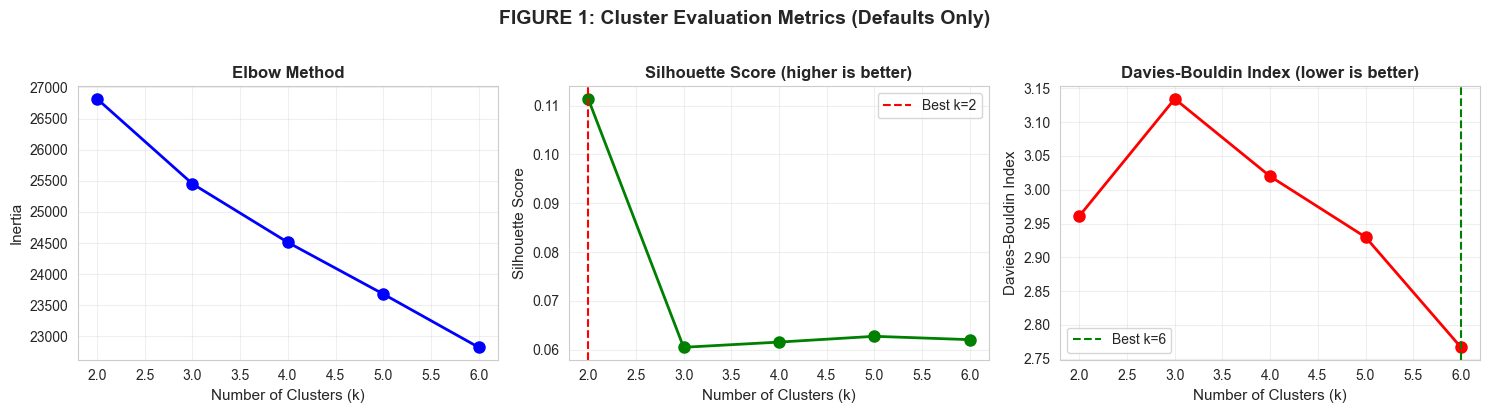


Recommendation:
  • Best k by Silhouette: 2
  • Best k by Davies-Bouldin: 6


In [57]:
# Visualize cluster evaluation metrics
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Elbow plot
axes[0].plot(results_df['k'], results_df['inertia'], 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)', fontsize=11)
axes[0].set_ylabel('Inertia', fontsize=11)
axes[0].set_title('Elbow Method', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3)

# Silhouette score (higher is better)
axes[1].plot(results_df['k'], results_df['silhouette'], 'go-', linewidth=2, markersize=8)
best_k_silhouette = int(results_df.loc[results_df['silhouette'].idxmax(), 'k'])
axes[1].axvline(x=best_k_silhouette, color='r', linestyle='--', 
                label=f'Best k={best_k_silhouette}')
axes[1].set_xlabel('Number of Clusters (k)', fontsize=11)
axes[1].set_ylabel('Silhouette Score', fontsize=11)
axes[1].set_title('Silhouette Score (higher is better)', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Davies-Bouldin index (lower is better)
axes[2].plot(results_df['k'], results_df['davies_bouldin'], 'ro-', linewidth=2, markersize=8)
best_k_db = int(results_df.loc[results_df['davies_bouldin'].idxmin(), 'k'])
axes[2].axvline(x=best_k_db, color='g', linestyle='--', 
                label=f'Best k={best_k_db}')
axes[2].set_xlabel('Number of Clusters (k)', fontsize=11)
axes[2].set_ylabel('Davies-Bouldin Index', fontsize=11)
axes[2].set_title('Davies-Bouldin Index (lower is better)', fontsize=12, fontweight='bold')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.suptitle('FIGURE 1: Cluster Evaluation Metrics (Defaults Only)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"\nRecommendation:")
print(f"  • Best k by Silhouette: {best_k_silhouette}")
print(f"  • Best k by Davies-Bouldin: {best_k_db}")

In [70]:
# Select optimal k
# For defaults-only clustering, we want interpretable archetypes (2-4 clusters is ideal)
k_optimal = 2

# If silhouette suggests too many clusters, cap at 4 for interpretability
if k_optimal > 4:
    k_optimal = 4
    print(f"Capping at k=4 for interpretability (silhouette suggested k={best_k_silhouette})")

print(f"\nSelected k = {k_optimal}")
print(f"  Silhouette score: {results_df[results_df['k']==k_optimal]['silhouette'].values[0]:.4f}")
print(f"  Davies-Bouldin: {results_df[results_df['k']==k_optimal]['davies_bouldin'].values[0]:.4f}")


Selected k = 2
  Silhouette score: 0.1114
  Davies-Bouldin: 2.9612


## 4. K-Means Clustering of Default Archetypes

In [71]:
# Fit final K-Means model on defaults only
print(f"Fitting K-Means with k={k_optimal} clusters on {len(shap_defaults):,} defaults...")
print("="*60)

kmeans_final = KMeans(n_clusters=k_optimal, random_state=42, n_init=10, max_iter=300)
cluster_labels = kmeans_final.fit_predict(shap_pca)

# Create analysis DataFrame for defaults
cluster_df = pd.DataFrame({
    'cluster': cluster_labels,
    'pd_lgbm': pd_defaults_lgbm,
    'pd_logit': pd_defaults_logit
}, index=X_defaults.index)

# Add 2D coordinates for visualization
cluster_df['umap_x'] = shap_2d[:, 0]
cluster_df['umap_y'] = shap_2d[:, 1]

# Cluster size summary
cluster_sizes = cluster_df['cluster'].value_counts().sort_index()
print(f"\nDefault Archetype Sizes:")
for c, size in cluster_sizes.items():
    print(f"  Archetype {c}: {size:,} firms ({size/len(cluster_df)*100:.1f}%)")

print(f"\n✓ Clustering of defaults complete")

Fitting K-Means with k=2 clusters on 1,071 defaults...

Default Archetype Sizes:
  Archetype 0: 648 firms (60.5%)
  Archetype 1: 423 firms (39.5%)

✓ Clustering of defaults complete


## 5. Default Archetype Characterization

For each archetype, we analyze:
1. Predicted PD distribution (how "expected" were these defaults?)
2. SHAP value profile (which features drove default in this group?)
3. Distinguishing characteristics (what makes this archetype unique?)

In [72]:
# Compute archetype-level statistics
print("="*90)
print("DEFAULT ARCHETYPE SUMMARY: Predicted Probabilities")
print("="*90)

cluster_summary = cluster_df.groupby('cluster').agg({
    'pd_lgbm': ['count', 'mean', 'median', 'std', 'min', 'max'],
    'pd_logit': 'mean'
}).round(4)

cluster_summary.columns = ['Size', 'Mean_PD_LightGBM', 'Median_PD_LightGBM', 
                           'Std_PD_LightGBM', 'Min_PD_LightGBM', 'Max_PD_LightGBM',
                           'Mean_PD_Logit']

# Add percentage of total defaults
cluster_summary['Pct_of_Defaults'] = (cluster_summary['Size'] / len(cluster_df) * 100).round(1)

print(cluster_summary.to_string())
print("\n" + "="*90)
print(f"Total defaults: {len(cluster_df):,}")
print(f"Overall mean predicted PD: {cluster_df['pd_lgbm'].mean()*100:.2f}%")
print("\nNote: High mean PD = 'expected' defaults; Low mean PD = 'surprise' defaults")

DEFAULT ARCHETYPE SUMMARY: Predicted Probabilities
         Size  Mean_PD_LightGBM  Median_PD_LightGBM  Std_PD_LightGBM  Min_PD_LightGBM  Max_PD_LightGBM  Mean_PD_Logit  Pct_of_Defaults
cluster                                                                                                                               
0         648            0.1582              0.1235           0.1278           0.0058           0.7045         0.1031             60.5
1         423            0.0449              0.0290           0.0464           0.0006           0.2817         0.0464             39.5

Total defaults: 1,071
Overall mean predicted PD: 11.35%

Note: High mean PD = 'expected' defaults; Low mean PD = 'surprise' defaults


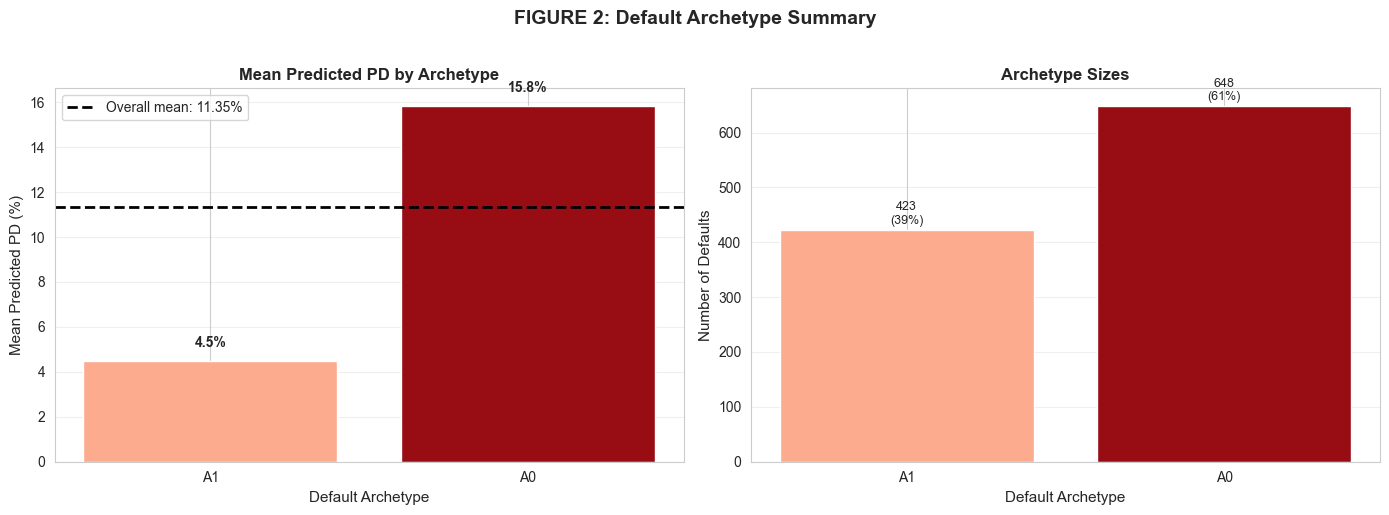

In [73]:
# Visualize predicted PD by archetype
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sort archetypes by mean predicted PD
cluster_order = cluster_summary.sort_values('Mean_PD_LightGBM').index.tolist()
colors = plt.cm.Reds(np.linspace(0.3, 0.9, k_optimal))

# 1. Mean predicted PD bar chart
sorted_pds = cluster_summary.loc[cluster_order, 'Mean_PD_LightGBM']
bars = axes[0].bar(range(k_optimal), sorted_pds * 100, color=colors)
axes[0].axhline(y=cluster_df['pd_lgbm'].mean()*100, color='black', linestyle='--', 
                linewidth=2, label=f'Overall mean: {cluster_df["pd_lgbm"].mean()*100:.2f}%')
axes[0].set_xticks(range(k_optimal))
axes[0].set_xticklabels([f'A{c}' for c in cluster_order])
axes[0].set_xlabel('Default Archetype', fontsize=11)
axes[0].set_ylabel('Mean Predicted PD (%)', fontsize=11)
axes[0].set_title('Mean Predicted PD by Archetype', fontsize=12, fontweight='bold')
axes[0].legend(loc='upper left')
axes[0].grid(alpha=0.3, axis='y')

for bar, pd_val in zip(bars, sorted_pds):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{pd_val*100:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 2. Archetype sizes
sorted_sizes = cluster_summary.loc[cluster_order, 'Size']
bars2 = axes[1].bar(range(k_optimal), sorted_sizes, color=colors)
axes[1].set_xticks(range(k_optimal))
axes[1].set_xticklabels([f'A{c}' for c in cluster_order])
axes[1].set_xlabel('Default Archetype', fontsize=11)
axes[1].set_ylabel('Number of Defaults', fontsize=11)
axes[1].set_title('Archetype Sizes', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')

for bar, size in zip(bars2, sorted_sizes):
    pct = size / len(cluster_df) * 100
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                f'{size:,}\n({pct:.0f}%)', ha='center', va='bottom', fontsize=9)

plt.suptitle('FIGURE 2: Default Archetype Summary', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [74]:
# Compute mean SHAP values per archetype
print("Computing SHAP profiles per default archetype...")

shap_df = pd.DataFrame(shap_defaults, columns=feature_names, index=X_defaults.index)
shap_df['cluster'] = cluster_labels

# Mean SHAP per archetype
cluster_shap_means = shap_df.groupby('cluster')[feature_names].mean()

# Overall mean SHAP for defaults
overall_default_shap = shap_df[feature_names].mean()

print(f"✓ Computed mean SHAP values for {k_optimal} archetypes")
print(f"  Shape: {cluster_shap_means.shape}")

Computing SHAP profiles per default archetype...
✓ Computed mean SHAP values for 2 archetypes
  Shape: (2, 29)


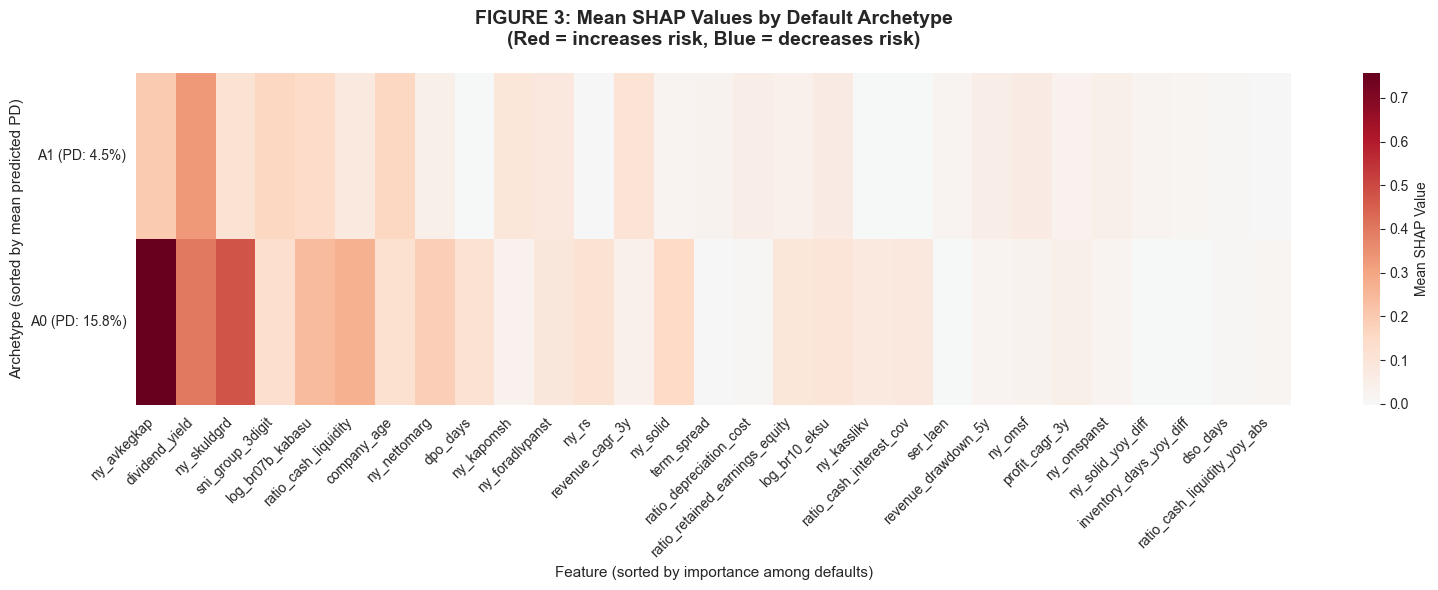

In [75]:
# Heatmap of mean SHAP values per archetype
fig, ax = plt.subplots(figsize=(16, 6))

# Sort features by overall importance (mean absolute SHAP across defaults)
feature_importance = np.abs(shap_defaults).mean(axis=0)
sorted_features = [feature_names[i] for i in np.argsort(feature_importance)[::-1]]

# Reorder columns
cluster_shap_sorted = cluster_shap_means[sorted_features]

# Sort rows by mean predicted PD
cluster_order_by_pd = cluster_summary.sort_values('Mean_PD_LightGBM').index.tolist()
cluster_shap_sorted = cluster_shap_sorted.loc[cluster_order_by_pd]

# Create heatmap
sns.heatmap(
    cluster_shap_sorted,
    annot=False,
    cmap='RdBu_r',
    center=0,
    ax=ax,
    cbar_kws={'label': 'Mean SHAP Value'}
)

# Add PD annotation to y-axis
ytick_labels = [f"A{c} (PD: {cluster_summary.loc[c, 'Mean_PD_LightGBM']*100:.1f}%)" 
                for c in cluster_order_by_pd]
ax.set_yticklabels(ytick_labels, rotation=0)

ax.set_xlabel('Feature (sorted by importance among defaults)', fontsize=11)
ax.set_ylabel('Archetype (sorted by mean predicted PD)', fontsize=11)
ax.set_title('FIGURE 3: Mean SHAP Values by Default Archetype\n(Red = increases risk, Blue = decreases risk)',
             fontsize=14, fontweight='bold', pad=20)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [76]:
# Identify top distinguishing features for each archetype
print("="*90)
print("TOP DISTINGUISHING FEATURES PER DEFAULT ARCHETYPE")
print("="*90)

archetype_descriptions = {}

for cluster_id in cluster_order_by_pd:
    cluster_shap = cluster_shap_means.loc[cluster_id]
    
    # Features with highest positive SHAP (strongest risk drivers)
    top_positive = cluster_shap.nlargest(5)
    
    # Features with lowest SHAP (relative protective factors - still positive for defaults)
    top_negative = cluster_shap.nsmallest(3)
    
    mean_pd = cluster_summary.loc[cluster_id, 'Mean_PD_LightGBM']
    size = int(cluster_summary.loc[cluster_id, 'Size'])
    pct = size / len(cluster_df) * 100
    
    print(f"\n{'─'*90}")
    print(f"Archetype {cluster_id}: {size:,} defaults ({pct:.0f}%) | Mean Predicted PD: {mean_pd*100:.1f}%")
    print(f"{'─'*90}")
    
    print(f"\n  PRIMARY RISK DRIVERS (highest positive SHAP):")
    for feat, val in top_positive.items():
        print(f"    • {feat}: {val:+.3f}")
    
    print(f"\n  RELATIVE STRENGTHS (lowest SHAP among defaults):")
    for feat, val in top_negative.items():
        print(f"    • {feat}: {val:+.3f}")
    
    # Store for later naming
    archetype_descriptions[cluster_id] = {
        'top_risk_drivers': top_positive.index.tolist()[:3],
        'mean_pd': mean_pd,
        'size': size
    }

print("\n" + "="*90)

TOP DISTINGUISHING FEATURES PER DEFAULT ARCHETYPE

──────────────────────────────────────────────────────────────────────────────────────────
Archetype 1: 423 defaults (39%) | Mean Predicted PD: 4.5%
──────────────────────────────────────────────────────────────────────────────────────────

  PRIMARY RISK DRIVERS (highest positive SHAP):
    • dividend_yield: +0.329
    • ny_avkegkap: +0.198
    • company_age: +0.162
    • sni_group_3digit: +0.161
    • log_br07b_kabasu: +0.145

  RELATIVE STRENGTHS (lowest SHAP among defaults):
    • ny_kasslikv: -0.004
    • ratio_cash_interest_cov: -0.001
    • dpo_days: +0.001

──────────────────────────────────────────────────────────────────────────────────────────
Archetype 0: 648 defaults (61%) | Mean Predicted PD: 15.8%
──────────────────────────────────────────────────────────────────────────────────────────

  PRIMARY RISK DRIVERS (highest positive SHAP):
    • ny_avkegkap: +0.758
    • ny_skuldgrd: +0.475
    • dividend_yield: +0.399
    • 

/var/folders/5c/7nyvkw450d38pmzqgbgq75wc0000gn/T/ipykernel_97817/878392876.py:30: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  legend_elements = [plt.scatter([], [], c=plt.cm.tab10(i/10), s=50,


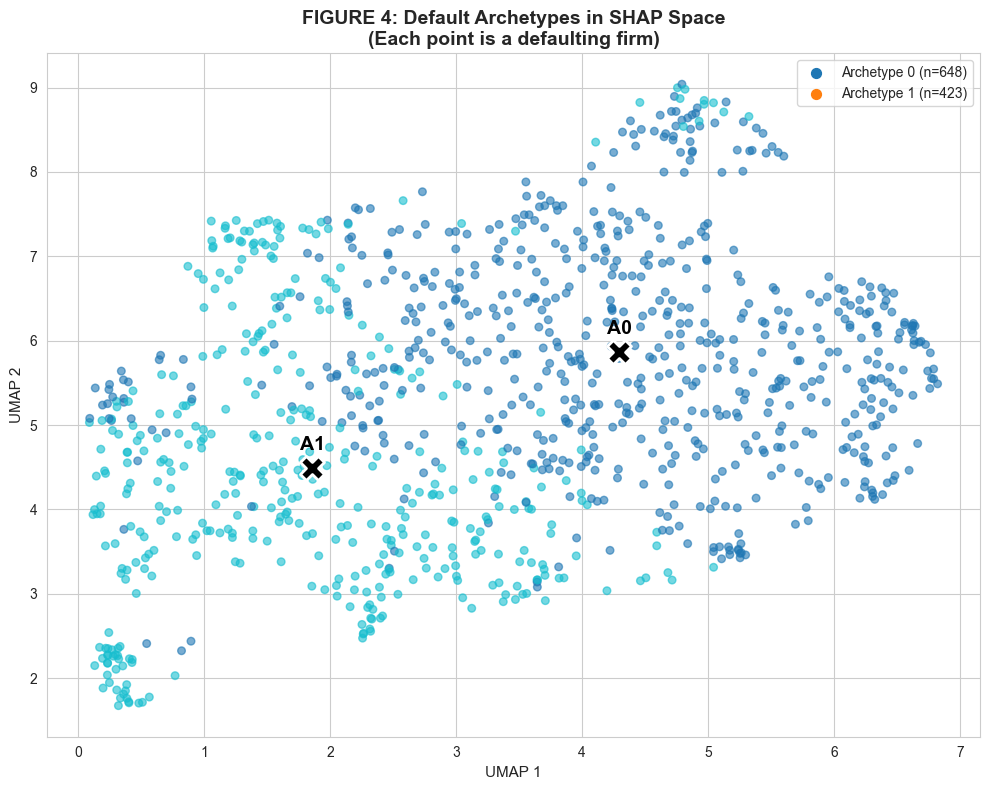

Note: Clusters represent different 'pathways to default' based on SHAP profiles.


In [77]:
# UMAP visualization of default archetypes
fig, ax = plt.subplots(figsize=(10, 8))

# Color by archetype
scatter = ax.scatter(
    cluster_df['umap_x'], 
    cluster_df['umap_y'],
    c=cluster_df['cluster'],
    cmap='tab10',
    alpha=0.6,
    s=30
)

# Add archetype centers
for c in range(k_optimal):
    mask = cluster_df['cluster'] == c
    cx = cluster_df.loc[mask, 'umap_x'].mean()
    cy = cluster_df.loc[mask, 'umap_y'].mean()
    ax.scatter([cx], [cy], c='black', s=300, marker='X', edgecolors='white', linewidths=2, zorder=10)
    ax.annotate(f'A{c}', (cx, cy), fontsize=14, fontweight='bold', 
                ha='center', va='bottom', color='black',
                xytext=(0, 10), textcoords='offset points')

ax.set_xlabel('UMAP 1', fontsize=11)
ax.set_ylabel('UMAP 2', fontsize=11)
ax.set_title('FIGURE 4: Default Archetypes in SHAP Space\n(Each point is a defaulting firm)', 
             fontsize=14, fontweight='bold')

# Add legend
legend_elements = [plt.scatter([], [], c=plt.cm.tab10(i/10), s=50, 
                               label=f'Archetype {i} (n={int(cluster_summary.loc[i, "Size"]):,})')
                   for i in range(k_optimal)]
ax.legend(handles=legend_elements, loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

print("Note: Clusters represent different 'pathways to default' based on SHAP profiles.")

## 6. Archetype Deep Dive: PD Distributions

How "expected" were these defaults? Archetypes with low predicted PD represent "surprise" defaults that the model failed to anticipate.

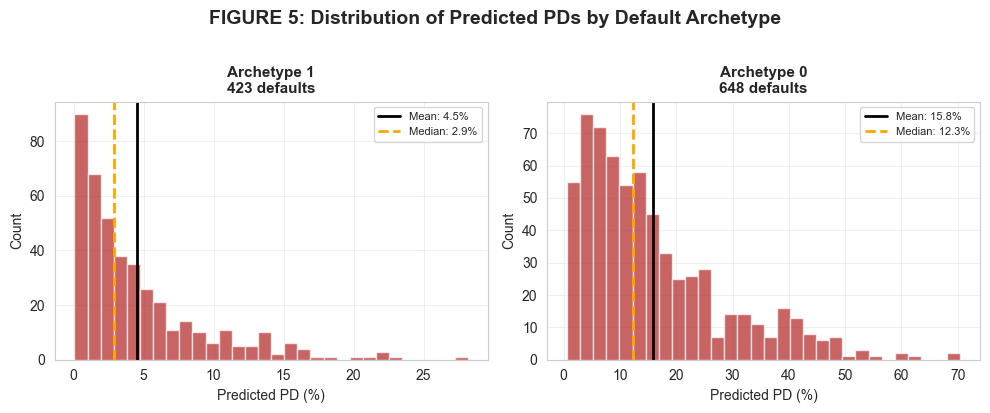


'Surprise' defaults (PD < 5%): 410 (38.3%)
These are firms the model did not expect to default.


In [78]:
# Distribution of predicted PDs within each archetype
n_cols = min(k_optimal, 3)
n_rows = (k_optimal + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
if k_optimal > 1:
    axes = axes.flatten() if n_rows > 1 or n_cols > 1 else [axes]
else:
    axes = [axes]

for i, cluster_id in enumerate(cluster_order_by_pd):
    ax = axes[i]
    cluster_data = cluster_df[cluster_df['cluster'] == cluster_id]
    
    # Histogram of PDs
    ax.hist(cluster_data['pd_lgbm'] * 100, bins=30, color='firebrick', 
            alpha=0.7, edgecolor='white')
    
    # Add vertical lines for mean and median
    mean_pd = cluster_data['pd_lgbm'].mean() * 100
    median_pd = cluster_data['pd_lgbm'].median() * 100
    ax.axvline(x=mean_pd, color='black', linestyle='-', linewidth=2, label=f'Mean: {mean_pd:.1f}%')
    ax.axvline(x=median_pd, color='orange', linestyle='--', linewidth=2, label=f'Median: {median_pd:.1f}%')
    
    size = int(cluster_summary.loc[cluster_id, 'Size'])
    ax.set_xlabel('Predicted PD (%)', fontsize=10)
    ax.set_ylabel('Count', fontsize=10)
    ax.set_title(f'Archetype {cluster_id}\n{size:,} defaults', 
                 fontsize=11, fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)

# Hide unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.suptitle('FIGURE 5: Distribution of Predicted PDs by Default Archetype', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Identify "surprise" defaults
low_pd_threshold = 0.05  # 5%
surprise_defaults = cluster_df[cluster_df['pd_lgbm'] < low_pd_threshold]
print(f"\n'Surprise' defaults (PD < {low_pd_threshold*100:.0f}%): {len(surprise_defaults):,} ({len(surprise_defaults)/len(cluster_df)*100:.1f}%)")
print("These are firms the model did not expect to default.")

## 7. Archetype Naming and Interpretation

Based on the SHAP profiles, we assign descriptive names to each archetype.

In [79]:
# Create archetype profile table
archetype_profiles = []

for cluster_id in range(k_optimal):
    cluster_shap = cluster_shap_means.loc[cluster_id]
    top_drivers = cluster_shap.nlargest(3).index.tolist()
    
    mean_pd = cluster_summary.loc[cluster_id, 'Mean_PD_LightGBM']
    size = int(cluster_summary.loc[cluster_id, 'Size'])
    
    # Classify by PD level
    if mean_pd > 0.10:
        pd_category = "High PD (expected defaults)"
    elif mean_pd > 0.05:
        pd_category = "Medium PD"
    else:
        pd_category = "Low PD (surprise defaults)"
    
    archetype_profiles.append({
        'archetype': cluster_id,
        'size': size,
        'pct_of_defaults': round(size / len(cluster_df) * 100, 1),
        'mean_pd_pct': round(mean_pd * 100, 1),
        'pd_category': pd_category,
        'top_risk_driver_1': top_drivers[0],
        'top_risk_driver_2': top_drivers[1],
        'top_risk_driver_3': top_drivers[2]
    })

archetype_profiles_df = pd.DataFrame(archetype_profiles)
archetype_profiles_df = archetype_profiles_df.sort_values('mean_pd_pct', ascending=False)

print("="*100)
print("FINAL DEFAULT ARCHETYPES")
print("="*100)
print(archetype_profiles_df.to_string(index=False))
print("="*100)

FINAL DEFAULT ARCHETYPES
 archetype  size  pct_of_defaults  mean_pd_pct                 pd_category top_risk_driver_1 top_risk_driver_2 top_risk_driver_3
         0   648             60.5         15.8 High PD (expected defaults)       ny_avkegkap       ny_skuldgrd    dividend_yield
         1   423             39.5          4.5  Low PD (surprise defaults)    dividend_yield       ny_avkegkap       company_age


## 8. Summary & Key Findings

In [80]:
# Final summary
print("="*90)
print("SUMMARY: Default Archetype Analysis")
print("="*90)

print(f"\n1. CLUSTERING RESULTS:")
print(f"   • Total defaults analyzed: {len(cluster_df):,}")
print(f"   • Number of archetypes: {k_optimal}")
print(f"   • Silhouette score: {results_df[results_df['k']==k_optimal]['silhouette'].values[0]:.4f}")
print(f"   • Dimensionality: {shap_defaults.shape[1]} → {shap_pca.shape[1]} (PCA)")

print(f"\n2. ARCHETYPE HETEROGENEITY:")
max_pd = cluster_summary['Mean_PD_LightGBM'].max()
min_pd = cluster_summary['Mean_PD_LightGBM'].min()
print(f"   • Highest archetype mean PD: {max_pd*100:.1f}%")
print(f"   • Lowest archetype mean PD: {min_pd*100:.1f}%")
print(f"   • PD spread across archetypes: {(max_pd - min_pd)*100:.1f} percentage points")

print(f"\n3. KEY FINDINGS:")
# Check if archetypes have meaningfully different SHAP profiles
shap_variance = cluster_shap_means.var(axis=0).mean()
print(f"   • Mean cross-archetype SHAP variance: {shap_variance:.4f}")

# Identify most heterogeneous features
feature_variance = cluster_shap_means.var(axis=0).sort_values(ascending=False)
print(f"   • Most differentiating features across archetypes:")
for feat, var in feature_variance.head(5).items():
    print(f"     - {feat}: variance = {var:.4f}")

print(f"\n4. INTERPRETATION:")
if max_pd - min_pd > 0.05:
    print("   → DISTINCT ARCHETYPES FOUND")
    print("   Different pathways to default exist, with varying degrees of predictability.")
    print("   Some defaults are 'expected' (high PD), others are 'surprises' (low PD).")
else:
    print("   → LIMITED ARCHETYPE DIFFERENTIATION")
    print("   Defaults form a relatively homogeneous group in SHAP space.")

print("\n" + "="*90)

SUMMARY: Default Archetype Analysis

1. CLUSTERING RESULTS:
   • Total defaults analyzed: 1,071
   • Number of archetypes: 2
   • Silhouette score: 0.1114
   • Dimensionality: 29 → 24 (PCA)

2. ARCHETYPE HETEROGENEITY:
   • Highest archetype mean PD: 15.8%
   • Lowest archetype mean PD: 4.5%
   • PD spread across archetypes: 11.3 percentage points

3. KEY FINDINGS:
   • Mean cross-archetype SHAP variance: 0.0102
   • Most differentiating features across archetypes:
     - ny_avkegkap: variance = 0.1569
     - ny_skuldgrd: variance = 0.0662
     - ratio_cash_liquidity: variance = 0.0185
     - ny_nettomarg: variance = 0.0097
     - ny_solid: variance = 0.0076

4. INTERPRETATION:
   → DISTINCT ARCHETYPES FOUND
   Different pathways to default exist, with varying degrees of predictability.
   Some defaults are 'expected' (high PD), others are 'surprises' (low PD).



In [81]:
# Save results
results_dir = PROJ_ROOT / "results" / "xai_clustering"
results_dir.mkdir(parents=True, exist_ok=True)

# Save cluster assignments (defaults only)
cluster_df.to_csv(results_dir / "cluster_assignments.csv")

# Save cluster summary
cluster_summary.to_csv(results_dir / "cluster_summary.csv")

# Save cluster SHAP profiles
cluster_shap_means.to_csv(results_dir / "cluster_shap_profiles.csv")

# Save archetype profiles
archetype_profiles_df.to_csv(results_dir / "cluster_archetypes.csv", index=False)

print(f"✓ Results saved to: {results_dir}")
print(f"  • cluster_assignments.csv ({len(cluster_df):,} defaults)")
print(f"  • cluster_summary.csv")
print(f"  • cluster_shap_profiles.csv")
print(f"  • cluster_archetypes.csv")

✓ Results saved to: /Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/results/xai_clustering
  • cluster_assignments.csv (1,071 defaults)
  • cluster_summary.csv
  • cluster_shap_profiles.csv
  • cluster_archetypes.csv
